<a href="https://colab.research.google.com/github/seunghyunmoon2/NLP/blob/master/NLP15_self_attention_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

## drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## konlpy

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Ign:13 https://developer.download.nvidia.com/comp

# data preprocess

In [ ]:
from konlpy.tag import Okt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import pickle

DATA_PATH = '/content/drive/My Drive/NLP/dataset/6-1.ChatBotData.csv'
VOCABULARY_PATH = '/content/drive/My Drive/NLP/dataset/6-1.vocabulary.voc'
TOKENIZE_AS_MORPH = False       # 형태소 분석 여부
ENC_INPUT = 0                   # encoder 입력을 의미함
DEC_INPUT = 1                   # decoder 입력을 의미함
DEC_TARGET = 2                  # decoder 출력을 의미함
MAX_SEQUENCE_LEN = 10           # 단어 시퀀스 길이

FILTERS = "([~.,!?\"':;)(])"
PAD = "<PADDING>"
STD = "<START>"
END = "<END>"
UNK = "<UNKNOWN>"

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

# 판다스를 통해서 데이터를 불러와 학습 셋과 평가 셋으로 나누어 그 값을 리턴한다.
def load_data():
    data_df = pd.read_csv(DATA_PATH, header=0)
    question, answer = list(data_df['Q']), list(data_df['A'])
    
    train_input, eval_input, train_label, eval_label = \
        train_test_split(question, answer, test_size=0.1, random_state=42)
        
    return train_input, train_label, eval_input, eval_label

# 형태소 분석
# 감성분석이나 문서 분류에는 형태소 분석이 필요하다. 하지만 답변 데이터에 형태소 분석을 
# 적용하면 형태소로 답변하게 된다.
def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

# 인코더, 디코더의 입력과 출력 데이터를 생성한다.
# 디코더 입력과 타켓에는 앞 뒤에 STD, END가 들어간다.
#
# 예시:
# DEFINES.max_sequence_length = 10 인 경우
# 인코더 입력 : "가끔 궁금해" -> [9310, 17707, 0, 0, 0, 0, 0, 0, 0, 0]
# 디코더 입력 : "그 사람도 그럴 거예요" -> [STD, 20190, 4221, 13697, 14552, 0, ...]
# 디코더 타켓 : [20190, 4221, 13697, 14552, END, 0, ...]
def data_processing(value, dictionary, pType):
    # 형태소 토크나이징 사용 유무
    if TOKENIZE_AS_MORPH:
        value = prepro_like_morphlized(value)

    sequences_input_index = []
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        
        if pType == DEC_INPUT:
            # 디코더 입력은 <START>로 시작한다.
            sequence_index = [dictionary[STD]]
        else:
            sequence_index = []
        
        for word in sequence.split():
            # word가 딕셔너리에 없으면 UNK (out of vacabulary)를 넣는다.
            if dictionary.get(word) is not None:
                sequence_index.append(dictionary[word])
            else:
                sequence_index.append(dictionary[UNK])
        
            # 문장의 단어수를  제한한다.
            if len(sequence_index) >= MAX_SEQUENCE_LEN:
                break
        
        # 디코더 출력은 <END>로 끝난다.
        if pType == DEC_TARGET:
            if len(sequence_index) < MAX_SEQUENCE_LEN:
                sequence_index.append(dictionary[END])
            else:
                sequence_index[len(sequence_index)-1] = dictionary[END]
                
        # max_sequence_length보다 문장 길이가 작으면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE_LEN - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index)

# 토크나이징
def data_tokenizer(data):
    words = []
    for sentence in data:
        sentence = re.sub(CHANGE_FILTER, "", sentence)
        for word in sentence.split():
            words.append(word)
    return [word for word in words if word]

# 사전 파일을 만든다
def make_vocabulary():
    data_df = pd.read_csv(DATA_PATH, encoding='utf-8')
    question, answer = list(data_df['Q']), list(data_df['A'])
    
    # 질문과 응답 문장의 단어를 형태소로 바꾼다
    if TOKENIZE_AS_MORPH:  
        question = prepro_like_morphlized(question)
        answer = prepro_like_morphlized(answer)
        
    data = []
    data.extend(question)
    data.extend(answer)
    words = data_tokenizer(data)
    words = list(set(words)) # 전처리로 좋은 방법이 아니다. 빈도가 높은 순서 쓰려면 - fit_on_texts()
    words[:0] = MARKER

    word2idx = {word: idx for idx, word in enumerate(words)}
    idx2word = {idx: word for idx, word in enumerate(words)}
    
    # 두가지 형태의 키와 값이 있는 형태를 리턴한다. 
    # (예) 단어: 인덱스 , 인덱스: 단어)
    return word2idx, idx2word

# 질문과 응답 문장 전체의 단어 목록 dict를 만든다.
word2idx, idx2word = make_vocabulary()

# 질문과 응답 문장을 학습 데이터와 시험 데이터로 분리한다.
train_input, train_label, eval_input, eval_label = load_data()

# 학습 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 만든다.
train_input_enc = data_processing(train_input, word2idx, ENC_INPUT)
train_input_dec = data_processing(train_label, word2idx, DEC_INPUT)
train_target_dec = data_processing(train_label, word2idx, DEC_TARGET)
	
# 평가 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 만든다.
eval_input_enc = data_processing(eval_input, word2idx, ENC_INPUT)
eval_input_dec = data_processing(eval_label, word2idx, DEC_INPUT)
eval_target_dec = data_processing(eval_label, word2idx, DEC_TARGET)

# 결과를 저장한다.
with open('/content/drive/My Drive/NLP/dataset/6-1.vocabulary.pickle', 'wb') as f:
    pickle.dump([word2idx, idx2word], f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/NLP/dataset/6-1.train_data.pickle', 'wb') as f:
    pickle.dump([train_input_enc, train_input_dec, train_target_dec], f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/NLP/dataset/6-1.eval_data.pickle', 'wb') as f:
    pickle.dump([eval_input_enc, eval_input_dec, eval_target_dec], f, pickle.HIGHEST_PROTOCOL)

# train - 수업

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dot
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Embedding, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Attention을 이용한 ChatBot : 학습 모듈
#
# 2020.06.04 : 조성현 (blog.naver.com/chunjein)
# ---------------------------------------------
from tensorflow.keras.layers import Input, LSTM, Dense, Dot
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Embedding, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

# 단어 목록 dict를 읽어온다.
with open('./dataset/6-1.vocabulary.pickle', 'rb') as f:
    word2idx,  idx2word = pickle.load(f)
    
# 학습 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 읽어온다.
with open('./dataset/6-1.train_data.pickle', 'rb') as f:
    trainXE, trainXD, trainYD = pickle.load(f)
	
# 평가 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 만든다.
with open('./dataset/6-1.eval_data.pickle', 'rb') as f:
    testXE, testXD, testYD = pickle.load(f)

VOCAB_SIZE = len(idx2word)
EMB_SIZE = 128
LSTM_HIDDEN = 128
MODEL_PATH = './dataset/6-6.Attention.h5'
LOAD_MODEL = True

# Encoder 출력과 decoder 출력으로 attention value를 생성하고,
# decoder 출력 + attention value (concatenate)를 리턴한다.
# x : encoder 출력, y : decoder 출력
# LSTM time step = 4, SMB_SIZE = 3 이라면 각 텐서의 dimension은
# 아래 주석과 같다.
def Attention(x, y):
    # step-1:
    # decoder의 매 시점마다 encoder의 전체 시점과 dot-product을 수행한다.
    score = Dot(axes=(2, 2))([y, x])                   # (1, 4, 4)
    
    # step-2:
    # dot-product 결과를 확률분포로 만든다 (softmax)
    # 이것이 attention score이다.
    dist = Activation('softmax')(score)                # (1, 4, 4)

    # step-3:    
    # encoder의 전체 시점에 위의 확률 분포를 적용해서 가중 평균한다.
    # 직접 계산이 어렵기 때문에 dist를 확장하고, 열을 복제해서
    # Dot 연산이 가능하도록 trick을 쓴다.
    # 이것이 attention value이다.
    # dist_exp = K.expand_dims(dist, 2)                   # (1, 4, 1, 4)
    # dist_rep = K.repeat_elements(dist_exp, EMB_SIZE, 2) # (1, 4, 3, 4)                                       
    # dist_dot = Dot(axes=(3, 1))([dist_rep, x])          # (1, 4, 3, 3)
    # attention = K.mean(dist_dot, axis = 2)              # (1, 4, 3)

    # step-4:
    # 교재의 step-3을 계산하지 않고 step-4를 직접 계산했다.
    attention = Dot(axes=(2, 1))([dist, x])
    
    # step-5:
    # decoder 출력과 attention을 concatenate 한다.
    return Concatenate()([y, attention])    # (1, 4, 6)
    
# 워드 임베딩 레이어. Encoder와 decoder에서 공동으로 사용한다.
K.clear_session()
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

# Encoder
# -------
# many-to-many로 구성한다. Attention value를 계산하기 위해 중간 출력이 필요하고
# (return_sequences=True), decoder로 전달할 h와 c도 필요하다 (return_state = True)
encoderX = Input(batch_shape=(None, trainXE.shape[1]))
encEMB = wordEmbedding(encoderX)
encLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
encLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
ey1, eh1, ec1 = encLSTM1(encEMB)    # LSTM 1층 
ey2, eh2, ec2 = encLSTM2(ey1)       # LSTM 2층

# Decoder
# -------
# many-to-many로 구성한다. target을 학습하고 Attention을 위해서는 중간 출력이 
# 필요하다. 그리고 초기 h와 c는 encoder에서 출력한 값을 사용한다 (initial_state)
# 최종 출력은 vocabulary의 인덱스인 one-hot 인코더이다.
decoderX = Input(batch_shape=(None, trainXD.shape[1]))
decEMB = wordEmbedding(decoderX)
decLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
decLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = decLSTM1(decEMB, initial_state = [eh1, ec1])
dy2, _, _ = decLSTM2(dy1, initial_state = [eh2, ec2])
att_dy2 = Attention(ey2, dy2)
decOutput = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
outputY = decOutput(att_dy2)

# Model
# -----
# target이 one-hot encoding되어 있으면 categorical_crossentropy
# target이 integer로 되어 있으면 sparse_categorical_crossentropy를 쓴다.
# sparse_categorical_entropy는 integer인 target을 one-hot으로 바꾼 후에
# categorical_entropy를 수행한다.
model = Model([encoderX, decoderX], outputY)
model.compile(optimizer=optimizers.Adam(lr=0.001), 
              loss='sparse_categorical_crossentropy')

if LOAD_MODEL:
    model.load_weights(MODEL_PATH)

# 학습 (teacher forcing)
# ----------------------
# loss = sparse_categorical_crossentropy이기 때문에 target을 one-hot으로 변환할
# 필요 없이 integer인 trainYD를 그대로 넣어 준다. trainYD를 one-hot으로 변환해서
# categorical_crossentropy로 처리하면 out-of-memory 문제가 발생할 수 있다.
hist = model.fit([trainXE, trainXD], trainYD, batch_size = 300, 
                 epochs=1, shuffle=True,
                 validation_data = ([testXE, testXD], testYD))

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 학습 결과를 저장한다
model.save_weights(MODEL_PATH)

# input pipeline

In [ ]:
with open('/content/drive/My Drive/NLP/dataset/6-1.vocabulary.pickle', 'rb') as f:
    word2idx,  idx2word = pickle.load(f)
    
# 학습 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 읽어온다.
with open('/content/drive/My Drive/NLP/dataset/6-1.train_data.pickle', 'rb') as f:
    trainXE, trainXD, trainYD = pickle.load(f)
	
# 평가 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 만든다.
with open('/content/drive/My Drive/NLP/dataset/6-1.eval_data.pickle', 'rb') as f:
    testXE, testXD, testYD = pickle.load(f)

In [ ]:
len(word2idx), len(idx2word)

(20705, 20705)

In [ ]:
idx2word[5]

'좋아하시니까'

In [ ]:
word2idx['좋아하시니까']

5

In [ ]:
type(trainXE), trainXE.shape, trainXD.shape, trainYD.shape

(numpy.ndarray, (10640, 10), (10640, 10), (10640, 10))

In [ ]:
testXE.shape, testXD.shape, testYD.shape

((1183, 10), (1183, 10), (1183, 10))

In [ ]:
trainXE[0], trainYD[0]

(array([6010, 6177, 7923, 5727,    0,    0,    0,    0,    0,    0]),
 array([ 9684, 17124,  9424,  7956,  3637,  2566,   523,     2,     0,
            0]))

In [ ]:
trainXE[0].reshape(1,-1)

array([[6010, 6177, 7923, 5727,    0,    0,    0,    0,    0,    0]])

In [ ]:
qqq = list(trainXE[0])
kkk = list(trainYD[0])
qqq,kkk

([6010, 6177, 7923, 5727, 0, 0, 0, 0, 0, 0],
 [9684, 17124, 9424, 7956, 3637, 2566, 523, 2, 0, 0])

In [ ]:
q = []
k = []
for x, y in zip(qqq,kkk):
    q.append(idx2word[x])
    k.append(idx2word[y])
q, k

(['나한테',
  '질리면',
  '어쩌지',
  '걱정돼',
  '<PADDING>',
  '<PADDING>',
  '<PADDING>',
  '<PADDING>',
  '<PADDING>',
  '<PADDING>'],
 ['당신의',
  '겉모습이',
  '아닌',
  '진정한',
  '내면의',
  '모습을',
  '보여주세요',
  '<END>',
  '<PADDING>',
  '<PADDING>'])

In [ ]:
trainXE.shape[1]

10

In [ ]:
EMB_SIZE = 128
MAX_SEQUENCE_LEN = trainXE.shape[1] # 10

# model build

## positional encoding

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
pe = positional_encoding(10,128)
pe.shape

TensorShape([1, 10, 128])

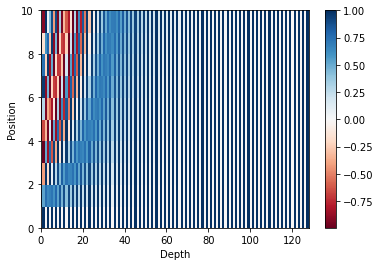

In [ ]:
plt.pcolormesh(pe[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
128, 10 맞음. maximum_position_encoding=10, dimension = 128

## masking

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## scaled dot product attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask): # (None, seq=10, num=heads=8, False)
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
print_out(trainXE[0].reshape(1,-1),trainXD[0].reshape(1,-1),trainXD[0].reshape(1,-1))

TypeError: ignored

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


### multi head attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## point wise feed forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## encoder and decoder

### encoder layer

In [ ]:
dimemsion 이 임베딩 개수 128
num_heads 가 8
EncoderLayer(10, )

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### decoder layer

In [ ]:
# Decoder layer
# Each decoder layer consists of sublayers:

# Masked multi-head attention (with look ahead mask and padding mask)
# Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
# Point wise feed forward networks
# Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

# There are N decoder layers in the transformer.

# As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### encoder 

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## create the transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## set hyperparameters

In [ ]:
# num_layers = 4
# d_model = 128
# dff = 512
# num_heads = 8

# input_vocab_size = tokenizer_pt.vocab_size + 2
# target_vocab_size = tokenizer_en.vocab_size + 2
# dropout_rate = 0.1

## optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

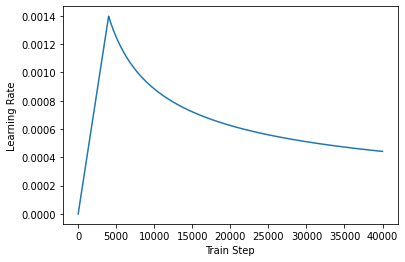

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## lost and metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## training and checkpointing

In [ ]:
num_layers = 2
d_model = 128
num_heads = 8
dff = 512

input_vocab_size = 10
target_vocab_size = 10
dropout_rate = 0.1

In [ ]:
# num_layers = 4
# d_model = 128
# dff = 512
# num_heads = 8

# input_vocab_size = tokenizer_pt.vocab_size + 2
# target_vocab_size = tokenizer_en.vocab_size + 2
# dropout_rate = 0.1

In [ ]:
test_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

a, b = test_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)
a, b

InvalidArgumentError: ignored

## evaluate